In [18]:
import os
import json
import numpy as np
from openai import AzureOpenAI
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#import umap
import umap.umap_ as umap


In [13]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT_EMBEDDINGS")
)

DEPLOYMENT_NAME = os.getenv("AZURE_DEPLOYMENT_NAME_EMBEDDINGS")
print(DEPLOYMENT_NAME)

text-embedding-ada-002


In [14]:
with open("agent_duplicate.json", "r") as f:
    agent_cards = json.load(f)

def flatten_agent(agent):
    parts = [agent["name"], agent["description"], " ".join(agent["capabilities"])]
    for skill in agent.get("skills", []):
        parts.extend([
            skill["name"], 
            skill["description"], 
            " ".join(skill["tags"]), 
            " ".join(skill["examples"])
        ])
    return " ".join(parts)

In [15]:
def embed_text(text):
    resp = client.embeddings.create(
        model=DEPLOYMENT_NAME,  
        input=text
    )
    return resp.data[0].embedding

agent_texts = [flatten_agent(a) for a in agent_cards]
agent_embeddings = np.array([embed_text(txt) for txt in agent_texts])
print(agent_embeddings)
print(agent_texts)


[[-0.01100136 -0.0062832  -0.01789941 ... -0.00342929 -0.00170478
  -0.01521647]
 [-0.01339118 -0.0260896  -0.00021465 ... -0.00622451 -0.02970584
   0.01207492]
 [-0.00089783 -0.01622104 -0.00434897 ...  0.01915818 -0.01357093
  -0.03172114]
 ...
 [-0.00418289 -0.01355716 -0.01632545 ...  0.01199366  0.02425805
   0.003215  ]
 [-0.00545427 -0.01389446  0.00239205 ...  0.01579217  0.02509496
  -0.00381202]
 [ 0.00012341 -0.02009292 -0.01603026 ... -0.0093923  -0.00040476
   0.00578756]]
['ESG Agent Helps with providing actionable strategies to improve ESG performance recommendations analysis ESG Improvement Advisor Helps with providing actionable strategies to improve ESG performance ESG Improvement Based on the ESG risk report, what are the top three recommendations for improvement?', 'Risk Profiler Agent Analyzes business operations and generates risk profiles based on industry and geography. risk_assessment data_analysis Risk Analysis Advisor Generates a detailed risk profile from g

In [19]:
# reducer = umap.UMAP(n_neighbors=5, n_components=20, metric='cosine', random_state=42)
# reduced_embeddings = reducer.fit_transform(agent_embeddings)

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(agent_embeddings)

clusterer = HDBSCAN(min_cluster_size=2,min_samples=1, metric="cosine")
labels = clusterer.fit_predict(agent_embeddings)

for i, agent in enumerate(agent_cards):
    agent["cluster"] = int(labels[i])

/Users/aryan_sinha/Desktop/Projects/Dataset_generation/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=10)
X = vectorizer.fit_transform(agent_texts)
terms = vectorizer.get_feature_names_out()

cluster_keywords = {}
for cluster_id in set(labels):
    if cluster_id == -1:  
        continue
    idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
    cluster_docs = X[idxs].toarray().sum(axis=0)
    top_idxs = cluster_docs.argsort()[::-1][:5]
    cluster_keywords[cluster_id] = [terms[i] for i in top_idxs]

In [21]:
def handle_query(query, top_k=3):
    query_emb = embed_text(query)

    if len(set(labels)) <= 1:
        sims = cosine_similarity([query_emb], agent_embeddings)[0]
        ranked = np.argsort(sims)[::-1][:top_k]
        return -1, ["global"], [(agent_cards[i], sims[i]) for i in ranked]

    cluster_centers = {}
    for cluster_id in set(labels):
        if cluster_id == -1:
            continue
        idxs = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        cluster_centers[cluster_id] = np.mean(agent_embeddings[idxs], axis=0)

    sims = {cid: cosine_similarity([query_emb], [emb])[0][0]
            for cid, emb in cluster_centers.items()}
    best_cluster = max(sims, key=sims.get)

    idxs = [i for i, lbl in enumerate(labels) if lbl == best_cluster]
    sims_agents = cosine_similarity([query_emb], agent_embeddings[idxs])[0]
    ranked = np.argsort(sims_agents)[::-1][:top_k]
    results = [(agent_cards[idxs[i]], sims_agents[i]) for i in ranked]
    return best_cluster, cluster_keywords.get(best_cluster, []), results

In [22]:
query = "Can you provide ESG improvement recommendations?"
cluster_id, keywords, results = handle_query(query)

print(f"Query routed to cluster {cluster_id} | Keywords: {keywords}\n")
for agent, score in results:
    print(f"Agent: {agent['name']} | Score: {score:.3f} | URL: {agent['url']}")

Query routed to cluster 1 | Keywords: ['compliance', 'esg', 'supplier', 'risk', 'data']

Agent: ESG Compliance Checker | Score: 0.810 | URL: http://localhost:8006/
Agent: Policy Gap Analyzer | Score: 0.804 | URL: http://localhost:8016/
Agent: Regulatory Compliance Agent | Score: 0.799 | URL: http://localhost:8015/


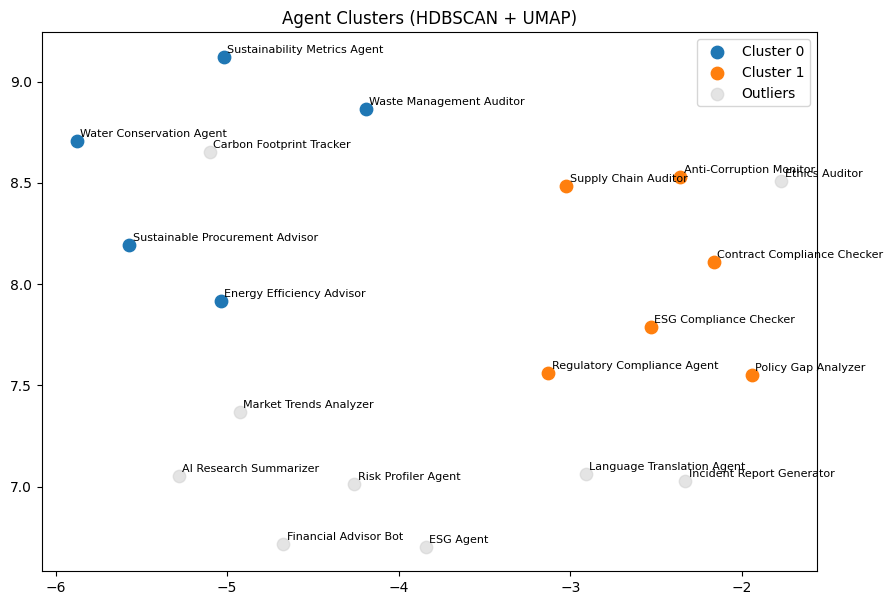

In [23]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
# embedding_2d = reducer.fit_transform(agent_embeddings)
# print(embedding_2d)

plt.figure(figsize=(10, 7))
for cluster_id in set(labels):
    mask = labels == cluster_id
    if cluster_id == -1:
        plt.scatter(
            embedding_2d[mask, 0], embedding_2d[mask, 1],
            color="lightgrey", label="Outliers", alpha=0.6, s=80
        )
    else:
        plt.scatter(
            embedding_2d[mask, 0], embedding_2d[mask, 1],
            label=f"Cluster {cluster_id}", s=80
        )

for i, agent in enumerate(agent_cards):
    plt.text(
        embedding_2d[i, 0] + 0.02, embedding_2d[i, 1] + 0.02,
        agent["name"], fontsize=8
    )

plt.title("Agent Clusters (HDBSCAN + UMAP)")
plt.legend()
plt.show()
